This tutorial introduces the scCausalVI model and demonstrates its application on interferon-beta-stimulated PBMC scRNA-seq data.

In [154]:
import os
import scanpy as sc
import scvi
import numpy as np
import pandas as pd
import anndata as ad
from scCausalVI.model.scCausalVI import scCausalVIModel

scvi.settings.seed = 0
import warnings
warnings.filterwarnings("ignore")

Global seed set to 0


In [2]:
file_path = "/Users/sa3520/Unfinished/CausalInferrence_Drug/Mycode10/testdata/ifnb_preprocess.h5ad"

In [3]:
adata = ad.read_h5ad(file_path)

In [4]:
adata = adata[adata.obs['cell'].notna()]

In [5]:
adata

View of AnnData object with n_obs × n_vars = 24673 × 35635
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets'
    var: 'V1', 'V2'

For users without a GPU, we begin with a smaller, subsampled dataset to enable a quicker demo. If GPU-based training is available, you may skip the subsampling step.

In [13]:
# Subsample data for efficiency if the user is not using a GPU
# Group by the 'stim' column in `adata.obs` and sample 30% of each group
adata_sampled = adata[adata.obs.groupby('stim', group_keys=False).apply(lambda x: x.sample(frac=0.3)).index]

# Verify the sample proportions are consistent
print(adata_sampled.obs['stim'].value_counts(normalize=True))
print(adata.obs['stim'].value_counts(normalize=True))

adata = adata_sampled

stim
stim    0.500878
ctrl    0.499122
Name: proportion, dtype: float64
stim
stim    0.500871
ctrl    0.499129
Name: proportion, dtype: float64


In [17]:
condition_key = 'stim'
group_key = 'cell'
n_conditions = len(adata.obs[condition_key].unique())
print(f"number of conditions: {n_conditions}")

number of conditions: 2


## Data Pre-processing
The pre-processing steps include filtering genes and cells, normalizing the data, and selecting highly variable genes.
Note that scCausalVI requires raw count data as input, so users should retain the count data prior to normalization.

In [18]:
sc.pp.filter_cells(adata, min_genes=50)
sc.pp.filter_genes(adata, min_cells=100)
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    flavor='seurat_v3',
    n_top_genes=1000,
    layer='counts',
    subset=True,
)

In [19]:
adata.obs[condition_key].value_counts()

stim
stim    3705
ctrl    3691
Name: count, dtype: int64

In [20]:
control_key='ctrl'
conditions = ['ctrl', 'stim',]  # make sure the first one is control data
group_indices_list = [np.where(adata.obs[condition_key]==group)[0] for group in conditions]
scCausalVIModel.setup_anndata(adata, labels_key=condition_key, layer='counts',)

In [21]:
condition2int = adata.obs.groupby(condition_key, observed=False)['_scvi_labels'].first().to_dict()
control = condition2int[control_key]

In [22]:
condition2int

{'ctrl': 0, 'stim': 1}

In [23]:
model = scCausalVIModel(
    adata, 
    control=control,
    n_conditions=n_conditions,
    n_layers=2,
    n_treat=n_conditions-1,
    n_background_latent=10,
    n_salient_latent=10,
    mmd_weight=10,
    cls_weight=0,
    mse_weight=0,
    norm_weight=0.2,
)

In [24]:
import torch
use_gpu = torch.cuda.is_available()

In [25]:
model.train(
    group_indices_list,
    use_gpu=use_gpu,
    max_epochs=200,
    early_stopping=True,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 200/200: 100%|█████████████████████████████████████████████████████████| 200/200 [34:06<00:00, 10.23s/it, loss=296, v_num=1]


## Visualiza latent data

First, we visualize the background latent space, where cells are expected to align according to cell type labels and display a well-mixed distribution across conditions.

In [ ]:
adata.obsm['latent_bg'], adata.obsm['latent_t'] = model.get_latent_representation()

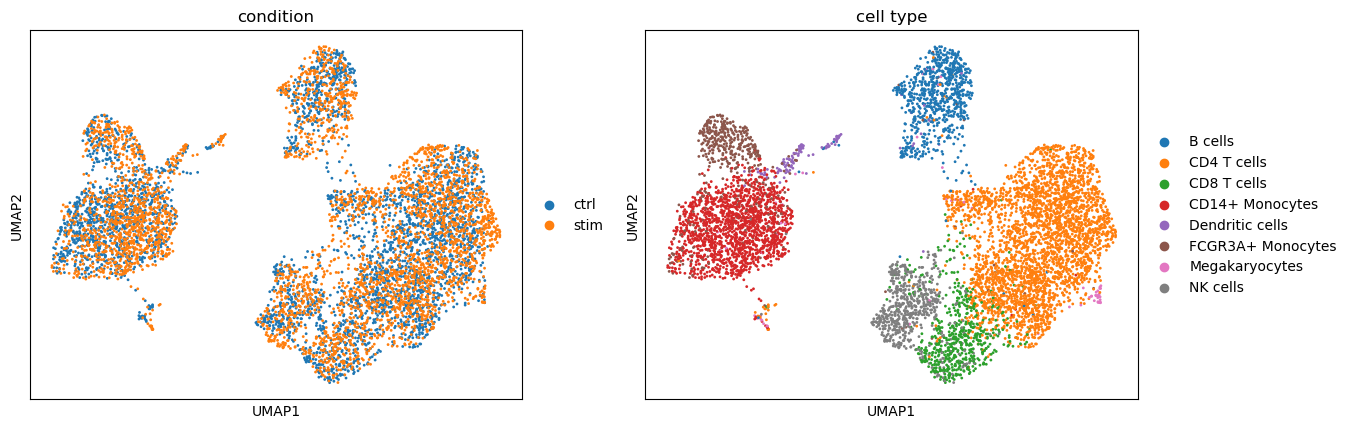

In [28]:
sc.pp.neighbors(adata, use_rep='latent_bg')
sc.tl.umap(adata)
sc.pl.umap(adata, color=[condition_key, group_key], title=['condition', 'cell type'])


Next, we visualize the treatment effect latent space for the stimulated data to examine the structure of the treatment effect.

In [30]:
adata_tm = adata[adata.obs[condition_key]=='stim'].copy()

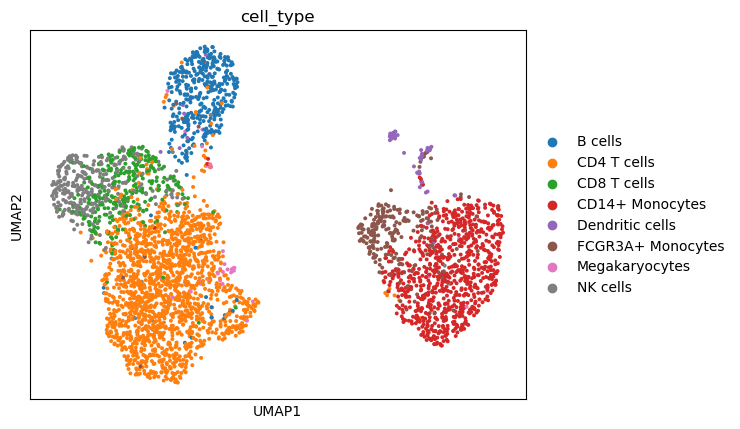

In [31]:
sc.pp.neighbors(adata_tm, use_rep='latent_t')
sc.tl.umap(adata_tm)
sc.pl.umap(adata_tm, color=group_key, title='cell_type')

We can quantify the treatment effect size by calculating the L2-norm of the treatment effect latent factors for each cell. This metric reflects the magnitude of each cell’s response to treatment. By grouping cells by type, we can assess the responsiveness of each cell type.

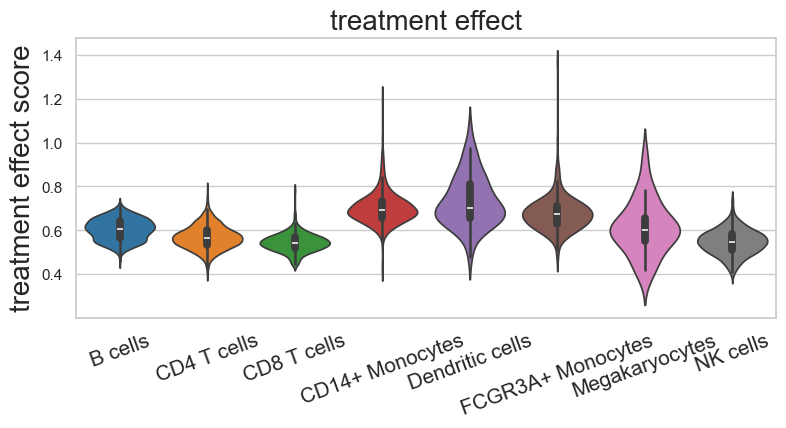

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(10, 4),)
te = ad.AnnData(X=adata_tm.obsm['latent_t'].copy(),
                obs=adata_tm.obs.copy(),
               )
te.obs['te'] = np.linalg.norm(te.X, axis=1)

palette = adata_tm.uns['cell_colors']

# sc.pl.violin(te, keys='te', groupby='cell', rotation=20, show=False, ax=ax, palette='Set2')
sns.violinplot(data=te.obs, x='cell', y='te', ax=ax, palette=palette)

ax.set_ylabel('treatment effect score', fontsize=20)
ax.set_xlabel('')
ax.set_title('treatment effect', fontsize=20)
ax.tick_params(axis='x', labelsize=15, rotation=20)

plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.2)


## Prediction accuracy
To assess the prediction accuracy of scCausalVI for downstream imputation analysis, we predict gene expression at the single-cell level and measure the prediction accuracy.

In [39]:
count_recon = model.get_count_expression()

In [41]:
adata_recon = ad.AnnData(
    X = count_recon, 
    obs = adata.obs.copy(),
    var = adata.var.copy()
)

sc.pp.normalize_total(adata_recon, target_sum=1e6)
sc.pp.log1p(adata_recon)

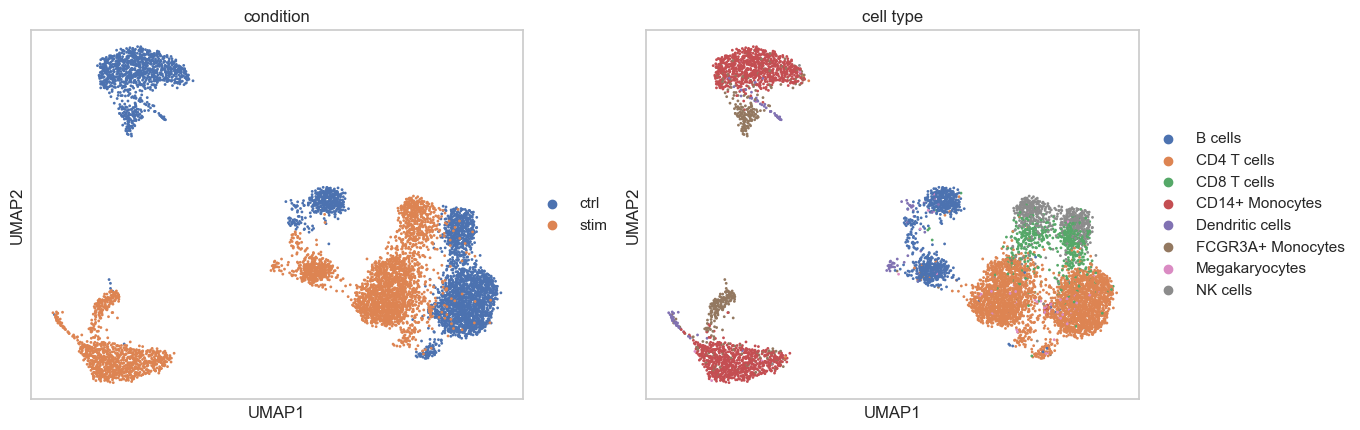

In [42]:
sc.pp.pca(adata_recon,)
sc.pp.neighbors(adata_recon)
sc.tl.umap(adata_recon)

sc.pl.umap(adata_recon, color=[condition_key, group_key,],
           title = ['condition', 'cell type'])

A joint visualization of the predicted and actual data reveals their consistency.

In [43]:
adata.obs['is_real'] = 'real'
adata_recon.obs['is_real'] = 'reconstructed'
adata_recon_real = ad.concat([adata, adata_recon])

In [44]:
sc.pp.pca(adata_recon_real)
sc.pp.neighbors(adata_recon_real)
sc.tl.umap(adata_recon_real)

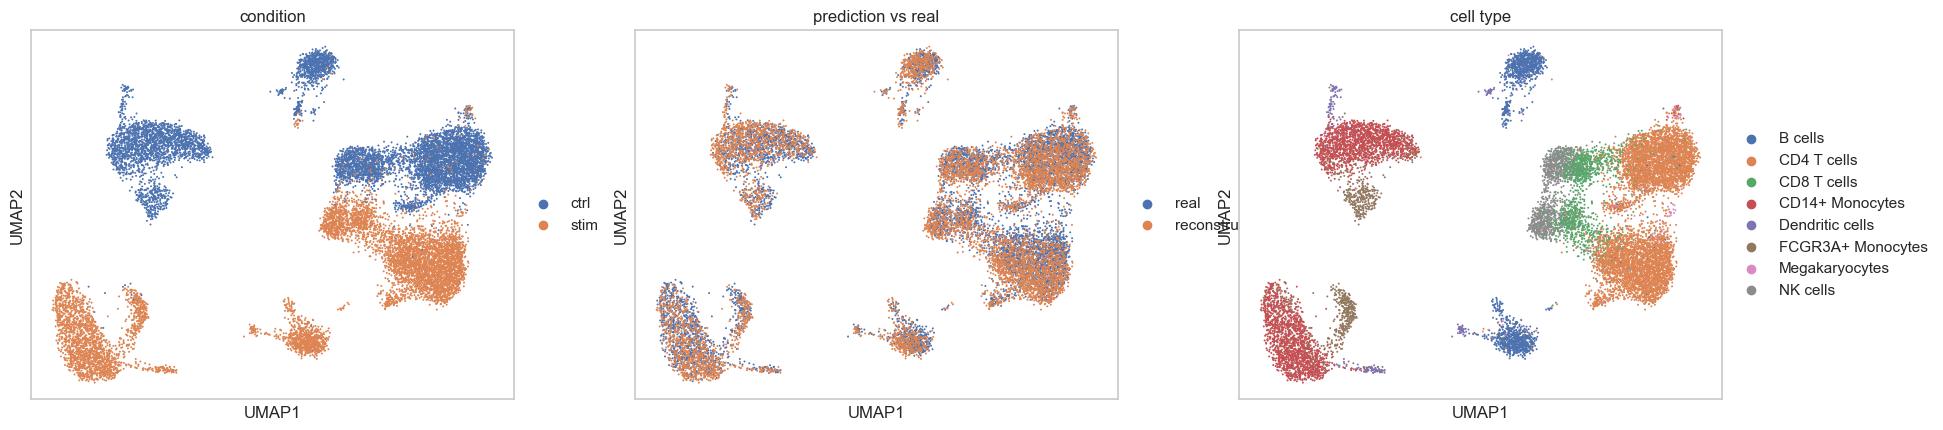

In [45]:
sc.pl.umap(
    adata_recon_real, 
    color = [condition_key, 'is_real', group_key],
    title = ['condition', 'prediction vs real', 'cell type']
)

## Counterfactual Inference 

Using cells from the 'source' condition, we can conduct an in-silico experiment in the 'target' condition at the single-cell level through counterfactual inference. This allows us to measure the changes in gene expression induced by perturbation, enabling further analysis of responsive or susceptible cells and identification of affected genes.

Here, we focus on the stimulated cells. To counterfactually predict their expression under the control condition, we set source_condition to 'stimulated' and target_condition to 'control'.

In [47]:
count_cf, _, _, _, _= model.get_count_expression_counterfactual(
    adata=adata_tm,
    source_condition='stim', 
    target_condition='ctrl',
    condition2int=condition2int,
)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


In [48]:
adata_cf = ad.AnnData(
    X = count_cf,
    obs = adata_tm.obs.copy(),
    var = adata_tm.var.copy()
)

sc.pp.normalize_total(adata_cf, target_sum=1e6)
sc.pp.log1p(adata_cf)

Visualize the real control data alongside the in-silico control data for comparison.

In [49]:
adata_ctrl = adata[adata.obs[condition_key] == 'ctrl'].copy()
adata_ctrl.obs['is_real'] = 'real ctrl'
adata_cf.obs['is_real'] = 'stim -> ctrl'

In [52]:
adata_cf_ctrl = ad.concat([adata_ctrl, adata_cf])
sc.pp.pca(adata_cf_ctrl)
sc.pp.neighbors(adata_cf_ctrl)
sc.tl.umap(adata_cf_ctrl)

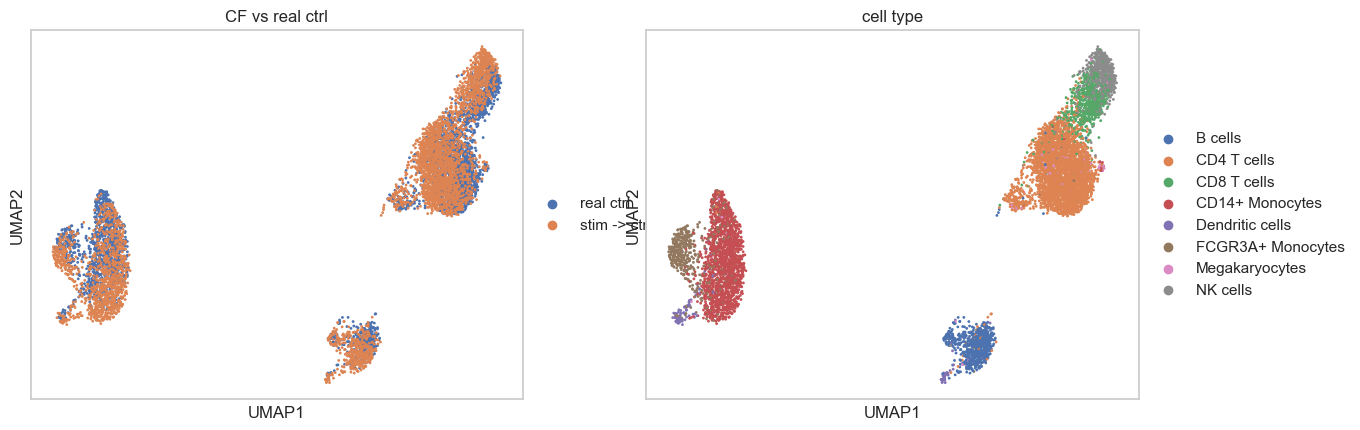

In [53]:
sc.pl.umap(
    adata_cf_ctrl, 
    color = ['is_real', group_key], 
    title = ['CF vs real ctrl', 'cell type']
)

## Permutation test to identify responsive cells in stimulated cohort

For each stimulated cell, we compute the factual prediction (reconstruction) and the counterfactual prediction under the control condition. The norm of the difference between the factual prediction and the real expression is used as a baseline, allowing us to assess whether the difference between the real data and the counterfactual control data is significant for each stimulated cell.

In this example, we examined the treated (stimulated) cells to identify those responsive to perturbation. Similarly, we can also perform the same analysis on control data to identify susceptible cells that would likely be affected if exposed to the treatment.

In [54]:
count_f = model.get_count_expression(adata_tm)

adata_stim_f = ad.AnnData(
    X = count_f, 
    obs = adata_tm.obs.copy(), 
    var = adata_tm.var.copy()
)
adata_stim_f.obs['is_real'] = 'stim -> stim'

sc.pp.normalize_total(adata_stim_f, target_sum=1e6)
sc.pp.log1p(adata_stim_f)

Compute the difference on PCA space.

In [56]:
from statsmodels.stats.multitest import multipletests

adata_tm.obs['is_real'] = 'real stim'

stim_real_pred = ad.concat([adata_tm, adata_stim_f, adata_cf_ctrl])

sc.pp.pca(stim_real_pred, n_comps=20)

diff_null = stim_real_pred[stim_real_pred.obs['is_real'] == "real stim"].obsm['X_pca'] - stim_real_pred[stim_real_pred.obs['is_real'] == "stim -> stim"].obsm['X_pca']

l2_norm_null = np.linalg.norm(diff_null, axis=1)

diff_cf = stim_real_pred[stim_real_pred. obs['is_real'] == "real stim"].obsm['X_pca'] - stim_real_pred[stim_real_pred.obs['is_real'] == "stim -> ctrl"].obsm['X_pca']
l2_norm_cf = np.linalg.norm(diff_cf, axis=1)

# Perform hypothesis testing
# Use the distribution of null hypothesis (l2_norm_null) to test the significance of l2_norm_cf
n = len(diff_null)
p_values = []
for l in l2_norm_cf:
    extreme_count = np.sum(l2_norm_null >= l)
    p_values.append((extreme_count + 1) / (n + 1))

# Apply multi-testing correction (e.g., Benjamini-Hochberg)
reject, pvals_corrected, _, _ = multipletests(p_values, method='fdr_bh')

significant_cells = np.where(reject)[0]

df = pd.DataFrame({
    "diff_null": l2_norm_null,
    "diff_cf": l2_norm_cf,
})


In [57]:
adata_tm.obs['-log p values'] = -np.log(pvals_corrected +1)
adata_tm.obs['if affected'] = 'False'
adata_tm.obs['if affected'][significant_cells] = 'True'

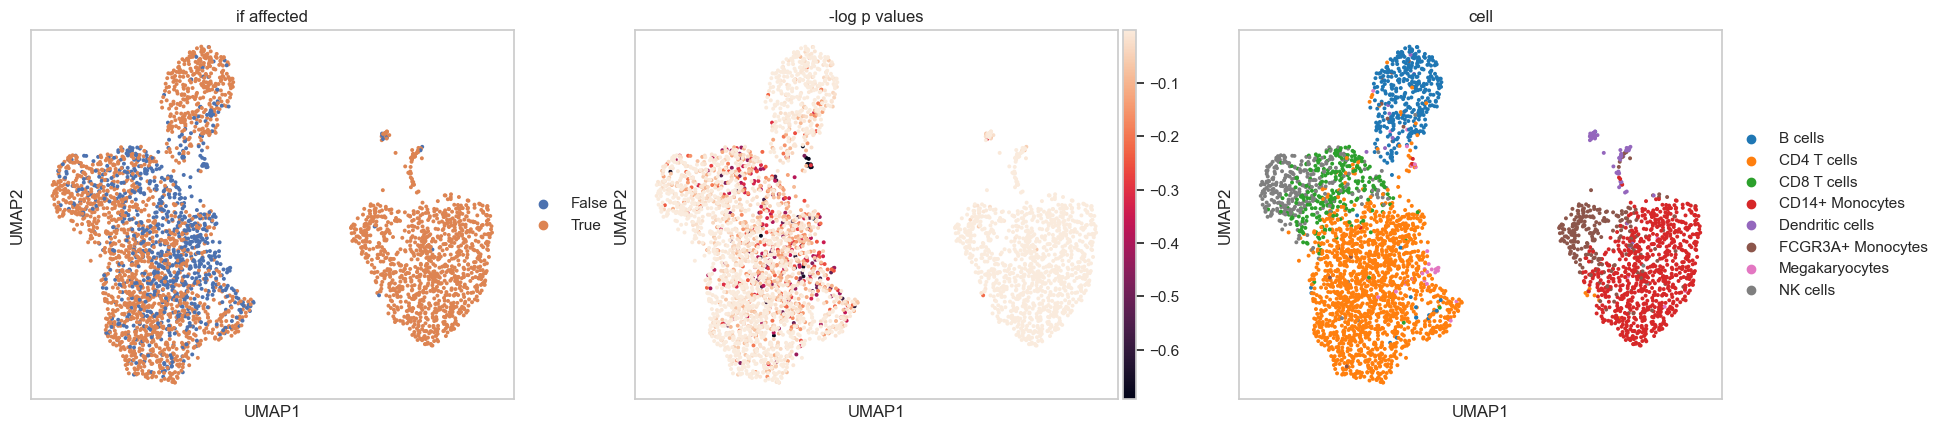

In [58]:
sc.pl.umap(adata_tm, color=['if affected', '-log p values', 'cell'],)

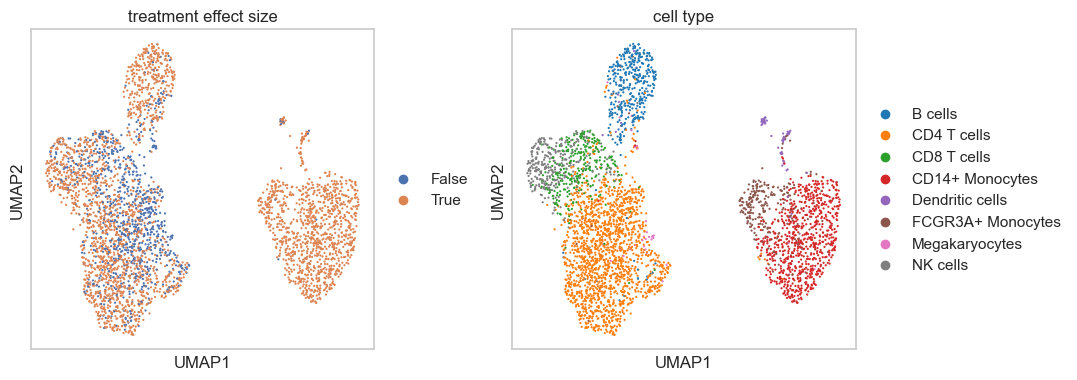

In [60]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4), gridspec_kw={'wspace':0.4}, )
sc.pl.umap(adata_tm, color='if affected', title= "treatment effect size", ax=ax1, size=10, 
           show=False, )
sc.pl.umap(adata_tm, color='cell', title= "cell type", ax=ax2, size=10, show=False,)
plt.subplots_adjust(left=0.03, right=0.78, top=0.9, bottom=0.1)

plt.show()

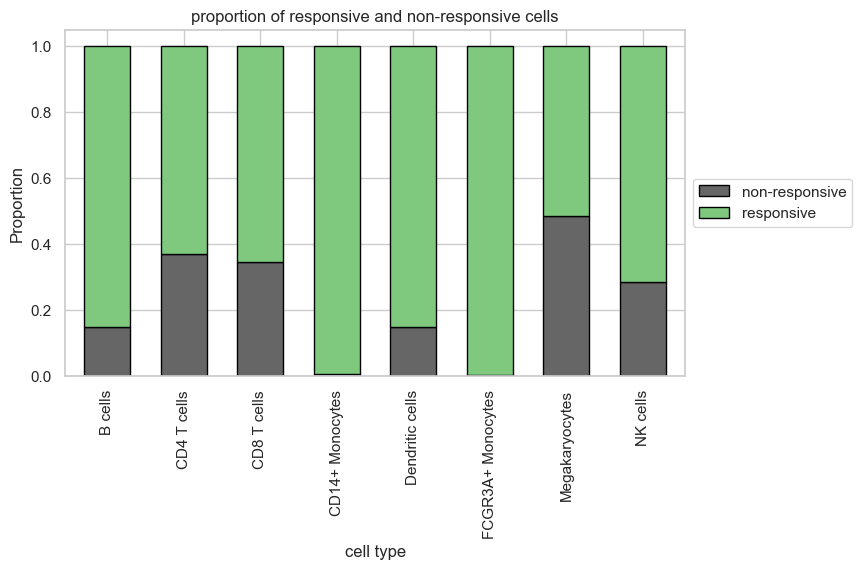

In [64]:
df_prop = adata_tm.obs[['cell', 'if affected']]

# Calculate the proportion of affected and unaffected cells for each cell type
proportion_df = df_prop.groupby(['cell', 'if affected']).size().unstack(fill_value=0)
proportion_df = proportion_df.div(proportion_df.sum(axis=1), axis=0)

# Plot the stacked bar chart
proportion_df.plot(kind='bar', stacked=True, colormap='Accent_r', figsize=(8,4.5), 
                   edgecolor='black', width=0.6)

# Add labels and title
plt.xlabel("cell type")
plt.ylabel("Proportion")
plt.title("proportion of responsive and non-responsive cells")
plt.legend(labels=['non-responsive', 'responsive'], 
           loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


## Analyze differential genes between susceptible and resistant cells

By distinguishing between responsive and non-responsive cells, we can compare phenotypic differences to identify potential driver genes. To do this, we conduct an in-silico experiment to predict expression under control conditions for both responsive and non-responsive cells within the stimulated cohort. Analyzing differential expression between these groups helps pinpoint key genes that contribute to each cell type's susceptibility. Here, we use CD8T cells as an example.

In [133]:
resp = adata_tm[adata_tm.obs['if affected'] == 'True'].copy()
resp = resp[resp.obs[group_key] == 'CD8 T cells']
nonresp = adata_tm[adata_tm.obs['if affected'] == 'False'].copy()
nonresp = nonresp[nonresp.obs[group_key] == 'CD8 T cells']

In [134]:
resp_cf, _, _, _, _ = model.get_count_expression_counterfactual(
    condition2int=condition2int,
    source_condition='stim',
    target_condition='ctrl',
    adata=resp
)

nonresp_cf, _, _, _, _ = model.get_count_expression_counterfactual(
    condition2int=condition2int,
    source_condition='stim',
    target_condition='ctrl',
    adata=nonresp
)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [135]:
resp_cf = ad.AnnData(X=resp_cf, obs=resp.obs.copy(), var=resp.var.copy())
nonresp_cf = ad.AnnData(X=nonresp_cf, obs=nonresp.obs.copy(), var=nonresp.var.copy())

sc.pp.normalize_total(resp_cf, target_sum=1e6)
sc.pp.log1p(resp_cf)

sc.pp.normalize_total(nonresp_cf, target_sum=1e6)
sc.pp.log1p(nonresp_cf)

resp_cf.obs['source'] = 'susceptible'
nonresp_cf.obs['source'] = 'resistant'

In [136]:
tm_cf = ad.concat([resp_cf, nonresp_cf])
tm_cf.var = resp_cf.var.copy()
tm_cf.var_names = resp_cf.var['V2']



Top genes for resistant:
['STOM', 'TMEM167A', 'S100A4', 'NUDT5', 'DUSP4', 'KLF6', 'CCL4', 'GPR183', 'GZMH', 'MED11']

Top genes for susceptible:
['GZMA', 'GAPDH', 'SSB', 'CEBPB', 'DUSP2', 'LGALS1', 'APOBEC3G', 'RGS1', 'ID2', 'PLA2G16']


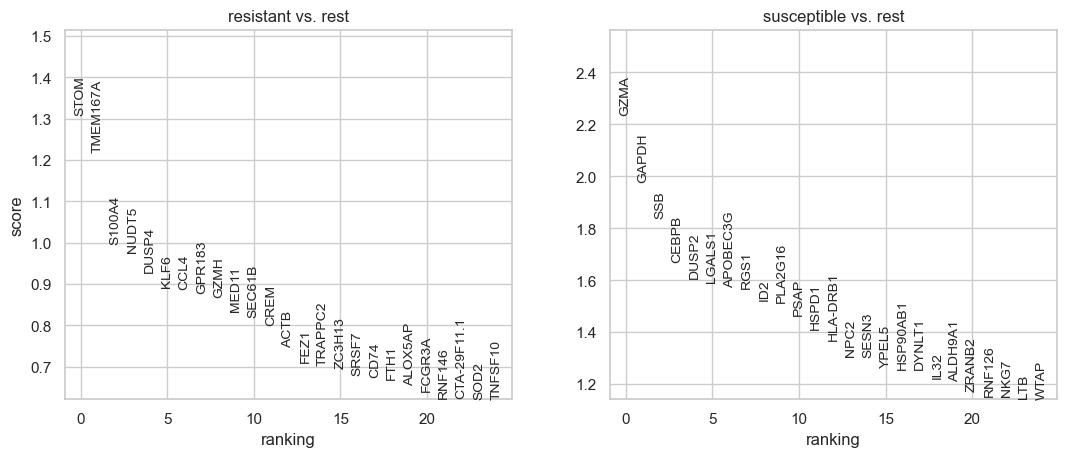

In [137]:
# Perform differential expression analysis
sc.tl.rank_genes_groups(tm_cf, 'source', method='wilcoxon')

# Create the rank_genes_groups plot
sc.pl.rank_genes_groups(tm_cf, n_genes=25, sharey=False, fontsize=10, show=False)

# Get the results
results = tm_cf.uns['rank_genes_groups']
groups = results['names'].dtype.names

# Function to get top differentially expressed genes
def get_top_genes(tm_cf, group, n_top=50):
    """Get top N differentially expressed genes for a group"""
    return [gene for gene in tm_cf.uns['rank_genes_groups']['names'][group][:n_top]]

# Print top differentially expressed genes for each group
for group in groups:
    print(f"\nTop genes for {group}:")
    print(get_top_genes(tm_cf, group, n_top=10))



In [143]:
control_cd8t.var_names

Index(['40', '42', '51', '52', '93', '149', '234', '236', '248', '320',
       ...
       '32350', '32406', '32436', '32437', '32543', '32594', '32595', '32599',
       '32612', '32645'],
      dtype='object', length=1000)

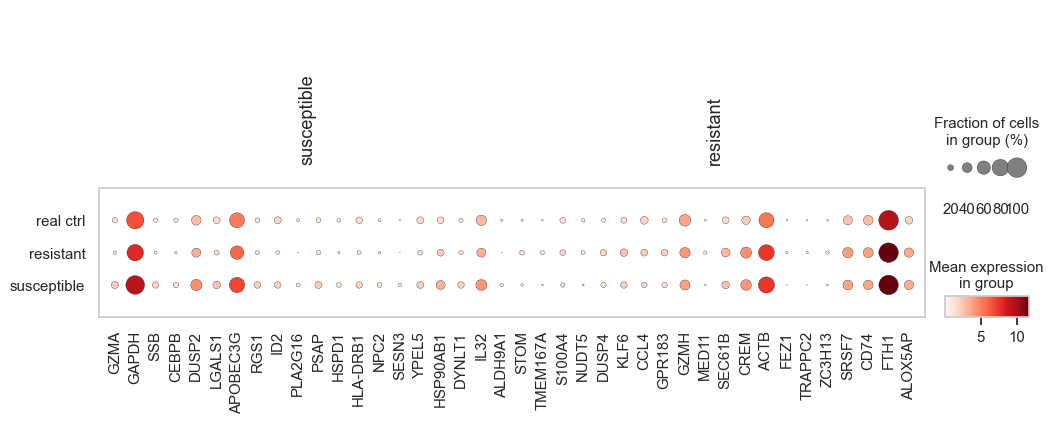

In [145]:
def get_top_genes(tm_cf, group, n_top=50):
    """Get top N differentially expressed genes for a group"""
    return [gene for gene in tm_cf.uns['rank_genes_groups']['names'][group][:n_top]]


plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(figsize=(12, 4))
control_cd8t = adata[(adata.obs[condition_key] == 'ctrl') & (adata.obs[group_key] == 'CD8 T cells')].copy()
control_cd8t.obs['source'] = 'real ctrl'
control_cd8t.var_names = adata.var['V2']
tt = ad.concat([control_cd8t, tm_cf])
markers = {'susceptible': get_top_genes(tm_cf, 'susceptible', n_top=20), 
           'resistant': get_top_genes(tm_cf, 'resistant', n_top=20)}

sc.pl.dotplot(tt, markers, groupby= 'source', show=False, ax=ax,)

plt.show()

## GO term analysis with differentially expressed genes
To explore the functionality of differentially expressed genes in each group, we can apply various functional analysis methods to the collected genes using standard analysis tools. Here, we use GO term analysis as an example.

In [146]:
n_top=25
top_genes_suscep = tm_cf.uns['rank_genes_groups']['names']['susceptible'][:n_top]
top_genes_resist = tm_cf.uns['rank_genes_groups']['names']['resistant'][:n_top]


In [147]:
import requests
import json

def get_enrichr_results(gene_list, database):
    ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
    genes_str = '\n'.join(gene_list)
    description = 'Example gene list'
    payload = {
        'list': (None, genes_str),
        'description': (None, description)
    }
    
    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error analyzing gene list')
    
    data = json.loads(response.text)
    user_list_id = data['userListId']
    
    ENRICHR_URL = f'http://maayanlab.cloud/Enrichr/enrich?userListId={user_list_id}&backgroundType={database}'
    response = requests.get(ENRICHR_URL)
    if not response.ok:
        raise Exception('Error fetching enrichment results')
    
    data = json.loads(response.text)
    return pd.DataFrame(data[database], columns=['Rank', 'Term', 'P-value', 'Z-score', 'Combined Score', 'Overlapping Genes', 'Adjusted P-value', 'Old P-value', 'Old Adjusted P-value'])

            

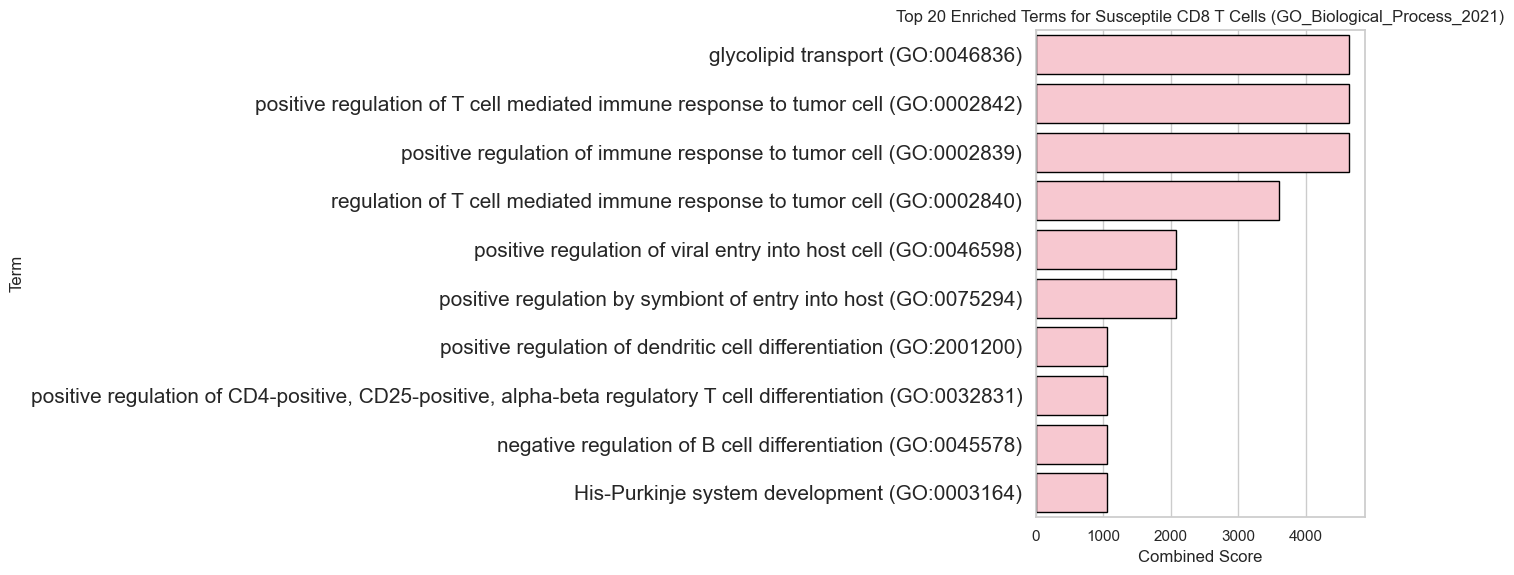

In [152]:

gene_list = top_genes_suscep
database = 'GO_Biological_Process_2021'
results_suscep = get_enrichr_results(gene_list, database)
plt.rcParams.update({'font.size': 15})

# results_aff = get_enrichr_results(gene_list, database)
results_suscep.sort_values(by='Combined Score', inplace=True, ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x='Combined Score', y='Term', data=results_suscep.head(10), edgecolor='black', color='pink',)
plt.title(f'Top 20 Enriched Terms for Susceptile CD8 T Cells ({database})')
plt.yticks(fontsize=15) 
plt.tight_layout()
plt.show()





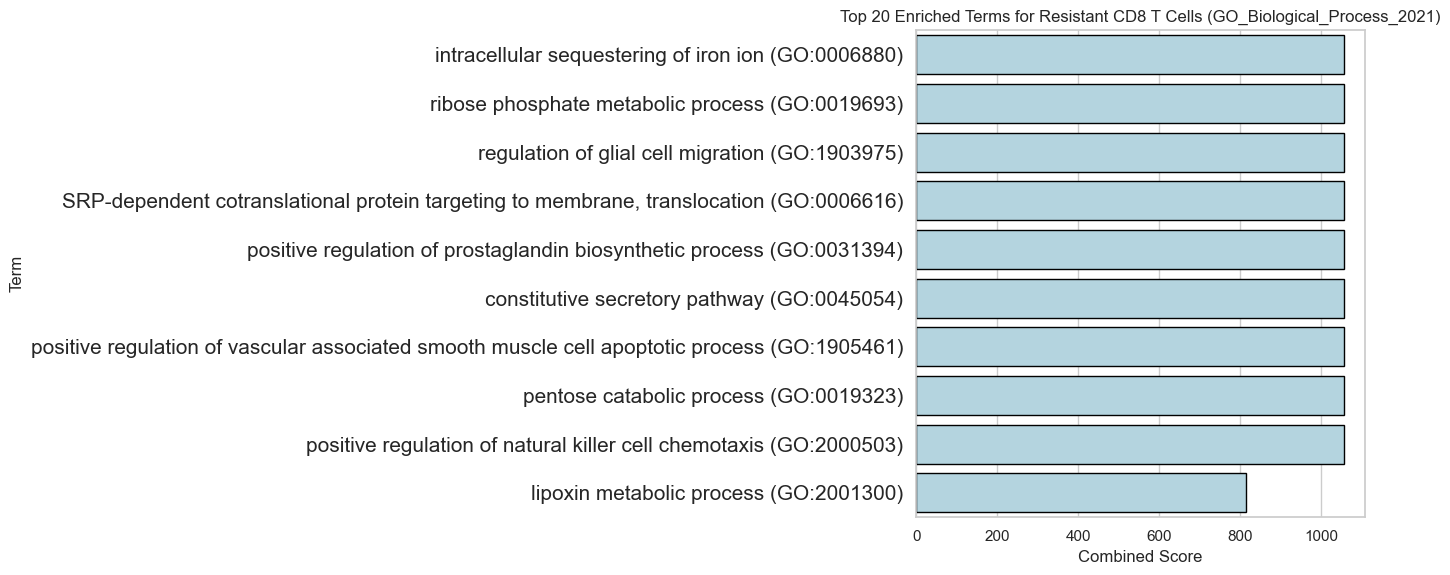

In [153]:

gene_list = top_genes_resist
database = 'GO_Biological_Process_2021'
results_suscep = get_enrichr_results(gene_list, database)
plt.rcParams.update({'font.size': 15})

# results_aff = get_enrichr_results(gene_list, database)
results_suscep.sort_values(by='Combined Score', inplace=True, ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x='Combined Score', y='Term', data=results_suscep.head(10), edgecolor='black', color='lightblue',)
plt.title(f'Top 20 Enriched Terms for Resistant CD8 T Cells ({database})')
plt.yticks(fontsize=15) 
plt.tight_layout()
plt.show()



